In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import time


from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix ,roc_curve,precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


In [4]:
telecom_churn_data = pd.read_csv("telecom_churn_data.csv")

In [5]:
telecom_churn_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [6]:
telecom_churn_data.shape

(99999, 226)

# Data Preparation

In [7]:
#Rename columns
telecom_churn_data.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7',\
                                   'aug_vbc_3g':'vbc_3g_8','sep_vbc_3g':'vbc_3g_9'},inplace=True)

## Identify high value customers


---


Now, we will have to calculate average total recharge amount. For this we have to 

1.   Calculate average of recharge amount from month June and July. 
2.   Calculate 70th percentile of average total recharge amount calculated in step 1
3.   Select only those customers records those have average recharge amount > 70th percentile value calculated in step 2 


---

In [8]:
[col for col in telecom_churn_data.columns if 'total' in col]

['total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'total_og_mou_9',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_ic_mou_9',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_num_9',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'total_rech_amt_9',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'total_rech_data_9']

In [9]:
#Derive Total Data Recharge Amounts
telecom_churn_data["total_rech_data_amt_6"] = telecom_churn_data["total_rech_data_6"]  * telecom_churn_data['av_rech_amt_data_6']
telecom_churn_data["total_rech_data_amt_7"] = telecom_churn_data["total_rech_data_7"]  * telecom_churn_data['av_rech_amt_data_7']
telecom_churn_data["total_rech_data_amt_8"] = telecom_churn_data["total_rech_data_8"]  * telecom_churn_data['av_rech_amt_data_8']
telecom_churn_data["total_rech_data_amt_9"] = telecom_churn_data["total_rech_data_9"]  * telecom_churn_data['av_rech_amt_data_9']

In [10]:
# Drop total_rech_data_* and av_rech_amt_data_*
drop_col = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8", "total_rech_data_9", 
                'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']
telecom_churn_data.drop(drop_col, axis=1, inplace=True)
print("--"*45)
print("Dropped columns :",drop_col)
print("--"*45)

------------------------------------------------------------------------------------------
Dropped columns : ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']
------------------------------------------------------------------------------------------


In [11]:
#Average of Recharge Amount in 6th and 7th Month
av_rech_amt_6n7 = (telecom_churn_data["total_rech_amt_6"].fillna(0) + telecom_churn_data["total_rech_data_amt_6"].fillna(0) + 
telecom_churn_data["total_rech_amt_7"].fillna(0) + telecom_churn_data["total_rech_data_amt_7"].fillna(0))/2.0

#70th Percentile of Avg Recharge Amount
Q70 = np.percentile(av_rech_amt_6n7, 70.0)
print('70 percentile of 6th and 7th months avg recharge amount: ', Q70)

telecom_churn_data = telecom_churn_data[av_rech_amt_6n7 >= Q70]
print('Dataframe Shape after Filtering HIgh Value Customers: ', telecom_churn_data.shape)

70 percentile of 6th and 7th months avg recharge amount:  478.0
Dataframe Shape after Filtering HIgh Value Customers:  (30001, 222)


# Data cleaning and EDA

In [12]:
#Remove Data which has only 1 unique Value

#List of columns with only 1 unqiue value
col_list = telecom_churn_data.loc[:,telecom_churn_data.apply(pd.Series.nunique) == 1]
col_list.head(5)

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9
0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN
7,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN
8,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#Remove Columns with only 1 unique value
telecom_churn_data = telecom_churn_data.loc[:,telecom_churn_data.apply(pd.Series.nunique) != 1]
telecom_churn_data.shape

(30001, 206)

In [14]:
#Checking object columns
telecom_churn_data_obj_cols = telecom_churn_data.select_dtypes(include=['object'])

# convert to datetime
for col in telecom_churn_data_obj_cols.columns:
    telecom_churn_data[col] = pd.to_datetime(telecom_churn_data[col])

telecom_churn_data.shape

(30001, 206)

In [15]:
def check_missing_values(df):
    missing_value_pct = df.isnull().sum()/df.shape[0]*100
    missing_value_df = pd.DataFrame(missing_value_pct).reset_index()
    missing_value_df.columns = ["Feature","MissingValuePct"]
    missing_value_df = missing_value_df[missing_value_df.MissingValuePct>0]
    #print(missing_value_df.sort_values(by='MissingValuePct',ascending=False))
    missing_value_df = missing_value_df.sort_values(by='MissingValuePct',ascending=False)  
    return missing_value_df   

In [16]:
missing_values_df = check_missing_values(telecom_churn_data)
missing_values_df[missing_values_df.MissingValuePct>30]['Feature'].unique()

array(['total_rech_data_amt_9', 'arpu_2g_9', 'date_of_last_rech_data_9',
       'max_rech_data_9', 'fb_user_9', 'count_rech_2g_9',
       'count_rech_3g_9', 'arpu_3g_9', 'night_pck_user_9',
       'date_of_last_rech_data_8', 'max_rech_data_8', 'count_rech_2g_8',
       'count_rech_3g_8', 'arpu_2g_8', 'arpu_3g_8',
       'total_rech_data_amt_8', 'night_pck_user_8', 'fb_user_8',
       'count_rech_3g_6', 'arpu_3g_6', 'max_rech_data_6',
       'total_rech_data_amt_6', 'count_rech_2g_6', 'night_pck_user_6',
       'fb_user_6', 'date_of_last_rech_data_6', 'arpu_2g_6',
       'count_rech_2g_7', 'date_of_last_rech_data_7', 'night_pck_user_7',
       'max_rech_data_7', 'total_rech_data_amt_7', 'arpu_2g_7',
       'arpu_3g_7', 'count_rech_3g_7', 'fb_user_7'], dtype=object)

In [17]:
# Drop columns with more than 30% missing values
telecom_churn_data.drop(missing_values_df[missing_values_df.MissingValuePct>30]['Feature'].unique(), axis=1, inplace=True)
telecom_churn_data.shape

(30001, 170)

In [18]:
missing_values_df = check_missing_values(telecom_churn_data)
missing_values_df

,Feature,MissingValuePct
76,loc_ic_t2t_mou_9,6.336455
96,std_ic_t2m_mou_9,6.336455
28,loc_og_t2m_mou_9,6.336455
104,std_ic_mou_9,6.336455
64,spl_og_mou_9,6.336455
100,std_ic_t2f_mou_9,6.336455
36,loc_og_t2c_mou_9,6.336455
40,loc_og_mou_9,6.336455
44,std_og_t2t_mou_9,6.336455
24,loc_og_t2t_mou_9,6.336455


In [19]:
telecom_churn_data.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('<M8[ns]')], dtype=object)

In [20]:
cat_cols = list(telecom_churn_data.select_dtypes(include='object').columns.values)
num_cols = list(telecom_churn_data.select_dtypes(include=np.number).columns.values)
date_cols = list(telecom_churn_data.select_dtypes(exclude=['object',np.number]).columns.values)
print("")
print("--"*42)
print("Categorical Cols :",cat_cols)
print("")
print("--"*42)
print("Date Cols :",date_cols)
print("")
print("--"*42)
print("Numerical Cols :",num_cols)
print("")
print("--"*42)


------------------------------------------------------------------------------------
Categorical Cols : []

------------------------------------------------------------------------------------
Date Cols : ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9']

------------------------------------------------------------------------------------
Numerical Cols : ['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 

In [21]:
telecom_churn_data[cat_cols] = telecom_churn_data[cat_cols].fillna('0')
telecom_churn_data[date_cols] = telecom_churn_data[date_cols].fillna(telecom_churn_data[date_cols].mode())
telecom_churn_data[num_cols] = telecom_churn_data[num_cols].fillna(0.0)

In [22]:
# Drop remaining rows with missing values
telecom_churn_data.dropna(axis=0,inplace=True)

In [23]:
missing_values = check_missing_values(telecom_churn_data)
if missing_values.shape[0] == 0:
    print("No more missing values in the dataset!!!")
else:
    print(missing_values)

No more missing values in the dataset!!!


In [24]:
telecom_churn_data.shape

(28757, 170)

## Tag churners

In [25]:
def churn(x):
    if (x['total_ic_mou_9'] == 0) & (x['total_og_mou_9'] == 0) & (x['vol_2g_mb_9'] == 0) & (x['vol_3g_mb_9'] == 0):
        return 1
    else:
        return 0
telecom_churn_data['churn'] = telecom_churn_data.apply(churn,axis=1)

In [26]:
# convert datatype to categorical
telecom_churn_data['churn'] = telecom_churn_data['churn'].astype('object')

In [27]:
# The classes are heavily skewed we need to solve this issue later.
print('No Churn', round(telecom_churn_data['churn'].value_counts()[0]/len(telecom_churn_data) * 100,2), '% of the dataset')
print('Churn', round(telecom_churn_data['churn'].value_counts()[1]/len(telecom_churn_data) * 100,2), '% of the dataset')

No Churn 93.99 % of the dataset
Churn 6.01 % of the dataset


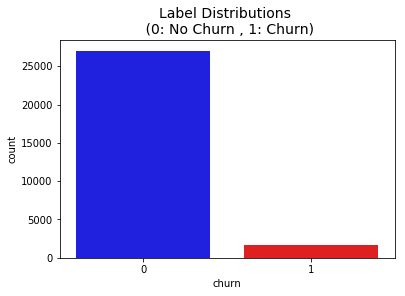

In [28]:
sns.countplot('churn', data=telecom_churn_data, palette=['blue','red'])
plt.title('Label Distributions \n (0: No Churn , 1: Churn)', fontsize=14)
plt.show()

---


**Above plot shows that data is highly imbalanced with around 91% of customers classified as non churn.**

---


## Drop columns from churn phase

In [29]:
telecom_churn_data.drop(labels= [col for col in telecom_churn_data.columns if '_9' in col] ,axis=1,inplace=True)

In [30]:
telecom_churn_data.shape

(28757, 129)

# Derived Metrics

Month 6 and 7 belong to "Good Phase" and month 8 belong to "Action Phase".<br>
So, we can average out month 6 and 7 numbers while month 8 values should be kept intact.

In [31]:
telecom_churn_data.select_dtypes(include=np.number).columns

Index(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'vbc_3g_8', 'vbc_3g_7',
       'vbc_3g_6'],
      dtype='object', length=125)

In [32]:
unique_cols = set()
col_list=[]
for i in [col for col in telecom_churn_data.select_dtypes(include=np.number).columns if '_6' in col or '_7' in col]:
    #print(i[:-2])
    unique_cols.add(i[:-2])
    col_list.append(i)

for col in list(unique_cols):
    new_col_name = 'avg_'+col+'_av67'
    col_6 = col+'_6'
    col_7 = col+'_7'
    telecom_churn_data[new_col_name] = (telecom_churn_data[col_6] + telecom_churn_data[col_7])/2.0
    
telecom_churn_data.shape    


(28757, 170)

In [33]:
telecom_churn_data.drop(columns=col_list,axis=1,inplace=True)
telecom_churn_data.shape

(28757, 88)

In [34]:
#Conevrt AON in Months
telecom_churn_data['aon_months'] = telecom_churn_data['aon']/30
telecom_churn_data.drop('aon', axis=1, inplace=True)
telecom_churn_data['aon_months'].head()

0     32.266667
7     26.733333
8     10.500000
21    24.000000
23    20.133333
Name: aon_months, dtype: float64

No Churn 93.99 % of the dataset
Churn 6.01 % of the dataset


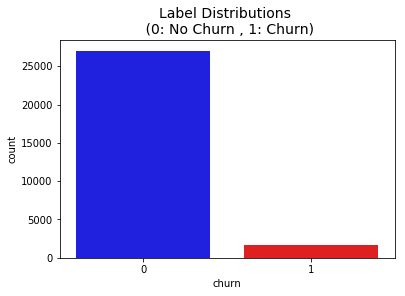

In [35]:
# churn Distribution on remaining data
print('No Churn', round(telecom_churn_data['churn'].value_counts()[0]/len(telecom_churn_data) * 100,2), '% of the dataset')
print('Churn', round(telecom_churn_data['churn'].value_counts()[1]/len(telecom_churn_data) * 100,2), '% of the dataset')

sns.countplot('churn', data=telecom_churn_data, palette=['blue','red'])
plt.title('Label Distributions \n (0: No Churn , 1: Churn)', fontsize=14)
plt.show()

In [36]:
%%time
cat_cols = list(telecom_churn_data.select_dtypes(include='object').columns.values)
num_cols = list(telecom_churn_data.select_dtypes(include=np.number).columns.values)
date_cols = list(telecom_churn_data.select_dtypes(exclude=['object',np.number]).columns.values)
print("")
print("--"*42)
print("Categorical Cols :",cat_cols)
print("")
print("--"*42)
print("Date Cols :",date_cols)
print("")
print("--"*42)
print("Numerical Cols :",num_cols)
print("")
print("--"*42)


------------------------------------------------------------------------------------
Categorical Cols : ['churn']

------------------------------------------------------------------------------------
Date Cols : ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

------------------------------------------------------------------------------------
Numerical Cols : ['mobile_number', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8', 'last_day

In [37]:
# Drop mobile number column
del telecom_churn_data['mobile_number']

# Feature scaling

In [38]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

rob_scaler = RobustScaler()

col_list = telecom_churn_data.select_dtypes(exclude='object').columns

for col in col_list:
  telecom_churn_data[col] = rob_scaler.fit_transform(telecom_churn_data[col].values.reshape(-1,1))

In [39]:
telecom_churn_data.describe(percentiles=[.25,.5,.75,.9,.99]).round(2)

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,...,avg_std_ic_t2m_mou_av67,avg_loc_ic_t2m_mou_av67,avg_vol_2g_mb_av67,avg_spl_og_mou_av67,avg_loc_ic_mou_av67,avg_std_ic_t2f_mou_av67,avg_loc_og_mou_av67,avg_loc_ic_t2f_mou_av67,avg_sachet_3g_av67,aon_months
count,28757.00,28757.00,28757.00,28757.00,28757.00,28757.00,28757.00,28757.00,28757.00,28757.00,...,28757.00,28757.00,28757.00,28757.00,28757.00,28757.00,28757.00,28757.00,28757.00,28757.00
mean,0.20,0.71,0.38,12.91,20.44,0.81,0.45,1.47,21.79,0.43,...,0.90,0.41,1.10,0.68,0.38,4.06,0.42,1.02,0.22,0.28
std,1.19,1.95,1.22,75.57,106.37,3.24,1.25,4.84,90.81,1.25,...,3.61,1.34,2.75,2.49,1.25,26.70,1.22,3.48,0.96,0.73
min,-1.85,-0.29,-0.48,0.00,0.00,-0.31,-0.38,0.00,0.00,-0.40,...,-0.28,-0.57,-0.06,-0.25,-0.59,0.00,-0.45,-0.21,0.00,-0.52
25%,-0.45,-0.24,-0.35,0.00,0.00,-0.27,-0.30,0.00,0.00,-0.31,...,-0.25,-0.34,-0.06,-0.25,-0.35,0.00,-0.31,-0.19,0.00,-0.30
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.55,0.76,0.65,0.00,0.00,0.73,0.70,1.00,1.00,0.69,...,0.75,0.66,0.94,0.75,0.65,1.00,0.69,0.81,0.00,0.70
90%,1.30,2.57,1.62,15.91,30.75,2.25,1.78,3.78,59.50,1.72,...,2.34,1.69,3.59,2.10,1.65,7.01,1.68,2.81,0.50,1.49
99%,3.66,8.82,5.06,288.04,433.72,12.74,5.45,20.30,357.04,5.35,...,14.08,5.67,12.55,8.70,5.33,68.77,5.22,14.82,4.00,2.14
max,78.12,44.85,34.82,4169.81,5337.04,150.39,26.11,228.69,4397.88,37.49,...,121.89,27.92,72.34,162.90,26.56,1742.71,21.86,106.13,27.00,2.65


In [40]:
cat_cols = list(telecom_churn_data.select_dtypes(include='object').columns.values)
num_cols = telecom_churn_data.select_dtypes(exclude='object').columns

telecom_churn_data[cat_cols] = telecom_churn_data[cat_cols].astype('int')

# Handling data imbalance

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Churn', round(telecom_churn_data['churn'].value_counts()[0]/len(telecom_churn_data) * 100,2), '% of the dataset')
print('Churn', round(telecom_churn_data['churn'].value_counts()[1]/len(telecom_churn_data) * 100,2), '% of the dataset')

X = telecom_churn_data.drop(['churn'], axis=1)
y = telecom_churn_data['churn']

sss = StratifiedKFold(n_splits=5, random_state=100, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Churn 93.99 % of the dataset
Churn 6.01 % of the dataset
Train: [ 5588  5593  5630 ... 28754 28755 28756] Test: [   0    1    2 ... 5763 5764 5765]
Train: [    0     1     2 ... 28754 28755 28756] Test: [ 5588  5593  5630 ... 11509 11520 11570]
Train: [    0     1     2 ... 28754 28755 28756] Test: [11499 11500 11502 ... 17466 17496 17501]
Train: [    0     1     2 ... 28754 28755 28756] Test: [17234 17236 17237 ... 23413 23428 23429]
Train: [    0     1     2 ... 23413 23428 23429] Test: [22978 22979 22980 ... 28754 28755 28756]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.9398444 0.0601556]
[0.94 0.06]


In [42]:
telecom_churn_data[telecom_churn_data.churn==1].shape[0]

1729

In [43]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

telecom_churn_data = telecom_churn_data.sample(frac=1)

# Number of churn labels 2546 rows.
churn_df = telecom_churn_data.loc[telecom_churn_data['churn'] == 1]
non_churn_df = telecom_churn_data.loc[telecom_churn_data['churn'] == 0][:telecom_churn_data[telecom_churn_data.churn==1].shape[0]]

normal_distributed_df = pd.concat([churn_df, non_churn_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,...,avg_std_ic_t2m_mou_av67,avg_loc_ic_t2m_mou_av67,avg_vol_2g_mb_av67,avg_spl_og_mou_av67,avg_loc_ic_mou_av67,avg_std_ic_t2f_mou_av67,avg_loc_og_mou_av67,avg_loc_ic_t2f_mou_av67,avg_sachet_3g_av67,aon_months
77333,0.830027,1.934089,1.702198,0.0,0.00,0.560336,0.612612,0.000000,1.375,0.453756,...,-0.150039,-0.208123,-0.059824,-0.198147,-0.307130,0.000000,-0.029525,-0.191781,0.0,-0.036725
4120,-1.034004,-0.294626,-0.470585,0.0,13.46,-0.309460,-0.380340,0.000000,0.000,-0.397440,...,1.686228,-0.409531,-0.059824,3.101212,-0.458573,0.000000,-0.365017,0.002740,0.0,0.222647
25007,-1.034004,-0.294626,-0.482205,0.0,0.00,-0.309460,-0.380340,0.000000,0.000,-0.397440,...,-0.193858,3.367533,-0.059824,-0.250178,2.539998,0.000000,1.243983,0.365558,0.0,-0.301454
15706,-0.455274,0.226952,0.371402,0.0,0.00,0.585144,0.753471,1.726601,0.000,0.574419,...,2.968310,0.110086,0.261912,0.484676,0.084199,0.000000,0.278034,1.086497,1.5,-0.290742
76734,-0.288919,-0.228338,-0.082245,0.0,0.00,-0.088157,0.325769,2.793103,0.000,0.149559,...,0.467136,0.887279,2.009256,-0.215966,0.495777,1.132353,0.382322,1.194912,0.0,2.140015


Distribution of the churn classes in the subsample dataset
1    0.5
0    0.5
Name: churn, dtype: float64


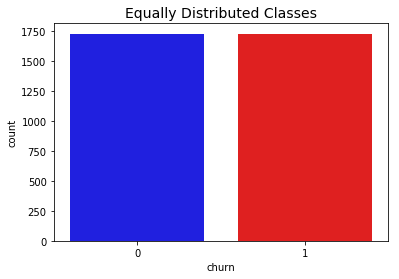

In [44]:
print('Distribution of the churn classes in the subsample dataset')
print(new_df['churn'].value_counts()/len(new_df))

sns.countplot('churn', data=new_df, palette=['blue','red'])
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [48]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop(['churn'], axis=1)
y = new_df['churn']
print("X.shape :",X.shape)
print("y.shape :",y.shape)

X.shape : (3458, 86)
y.shape : (3458,)


# Dimensionality reduction with PCA

In [49]:
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(X.values)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [50]:
colnames = list(X.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,PC1,PC2,Feature
0,0.001577,0.001048,arpu_8
1,0.001444,0.000362,onnet_mou_8
2,0.000768,0.000512,offnet_mou_8
3,0.450576,0.076880,roam_ic_mou_8
4,0.843882,0.114106,roam_og_mou_8


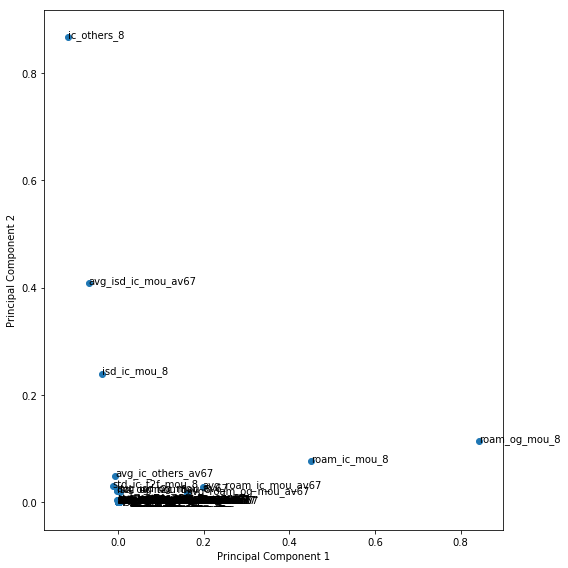

In [51]:
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

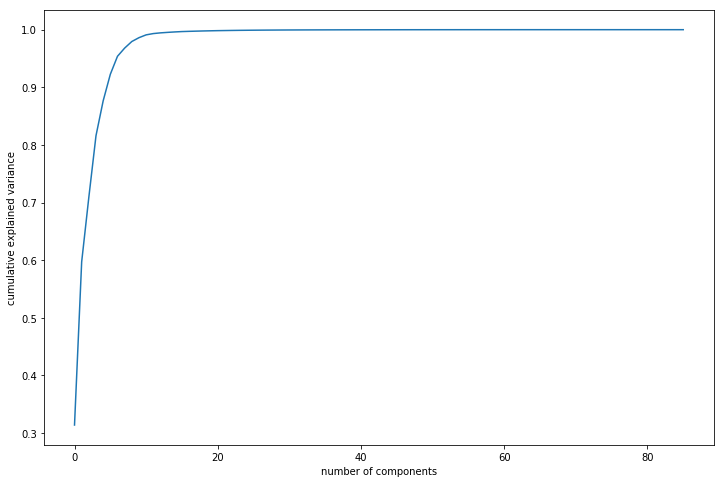

In [52]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [53]:
pca_again = PCA(0.90)
df_test = pca_again.fit_transform(X.values)
df_test.shape

(3458, 6)

In [54]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=df_test.shape[1])

In [55]:
X_reduced_pca = pca_final.fit_transform(X.values)
X_reduced_pca.shape

(3458, 6)

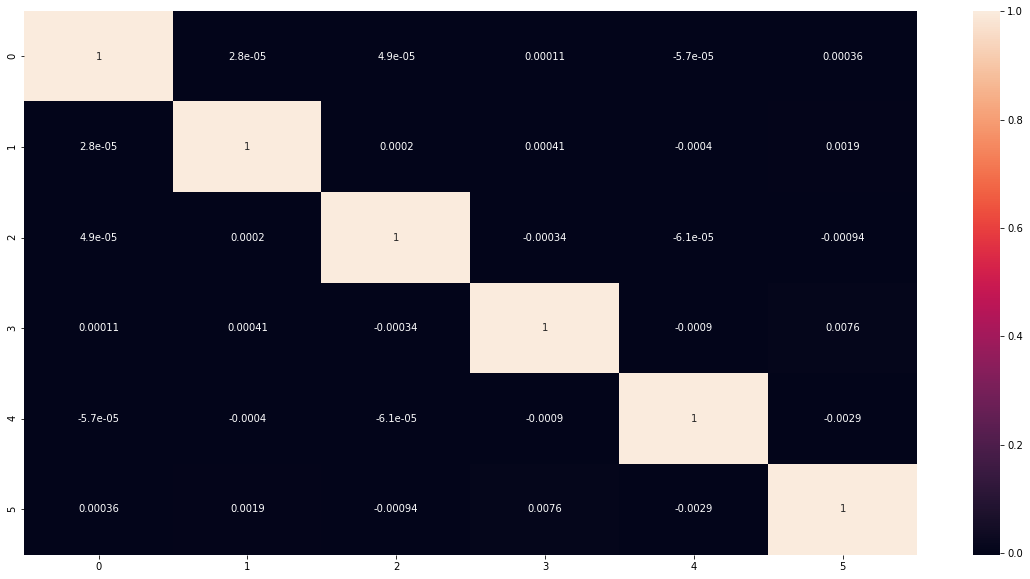

In [56]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(X_reduced_pca.transpose())

#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)
plt.show()

---

There is no correlationship between selected principal components. So, PCA has done a good job.

---


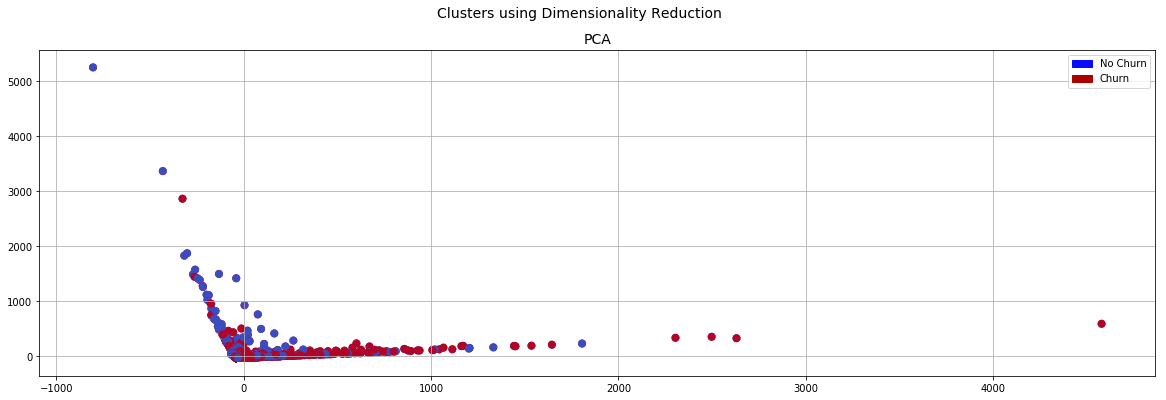

In [58]:
import matplotlib.patches as mpatches

f, ax1 = plt.subplots(1, 1, figsize=(20,6))
# labels = ['No Churn', 'Churn']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Churn')
red_patch = mpatches.Patch(color='#AF0000', label='Churn')

# PCA scatter plot
ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Churn', linewidths=2)
ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Churn', linewidths=2)
ax1.set_title('PCA', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# Model building

## Logistics Regression

In [59]:
%%time
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression(random_state=100)

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(log_reg_sm, log_reg_params, n_iter=4)


for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("Train accuracy: {}".format(np.mean(accuracy_lst)))
print("Train precision: {}".format(np.mean(precision_lst)))
print("Train recall: {}".format(np.mean(recall_lst)))
print("Train f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 23007 | Length of y (train): 23007
Length of X (test): 5750 | Length of y (test): 5750
---------------------------------------------------------------------------------------------------------------------------------------

Train accuracy: 0.832746633550107
Train precision: 0.2428289763354794
Train recall: 0.8403442682990635
Train f1: 0.37677192674219656
---------------------------------------------------------------------------------------------------------------------------------------
Wall time: 54min 1s


In [60]:
labels = ['No Churn', 'Churn']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Churn       0.99      0.83      0.90      5405
       Churn       0.23      0.83      0.37       345

    accuracy                           0.83      5750
   macro avg       0.61      0.83      0.63      5750
weighted avg       0.94      0.83      0.87      5750



In [61]:
y_score = best_est.decision_function(original_Xtest)
print("y_score :",y_score)

y_score : [ -2.17370813  -5.42290195   0.65330157 ...  -5.44308055 -11.37825654
  -2.93283172]


In [62]:
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.40


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.40')

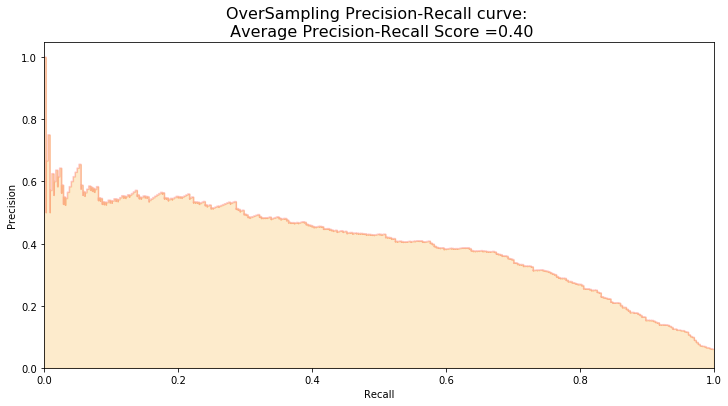

In [63]:

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [64]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)

Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [65]:
print(Xsm_train.shape)
print(ysm_train.shape)

(43246, 86)
(43246,)


In [66]:
# Build Logistic Regression model using best estimators chosen by RandomizedSearchCV
t0 = time.time()
log_reg_sm = rand_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :128.74165725708008 sec


### Predictions on test data

In [69]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(original_Xtest)

log_reg_cf = confusion_matrix(original_ytest, y_pred_log_reg)
print(log_reg_cf.round())

print("Test recall score: ",recall_score(original_ytest, y_pred_log_reg).round(2)*100,"%")
print("Test precision_score: ",precision_score(original_ytest, y_pred_log_reg).round(2)*100,"%")
print("Test roc_auc_score: ",roc_auc_score(original_ytest, y_pred_log_reg).round(2)*100,"%")

[[4459  946]
 [  58  287]]
Test recall score:  83.0 %
Test precision_score:  23.0 %
Test roc_auc_score:  83.0 %


### ROC Curve

In [71]:

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

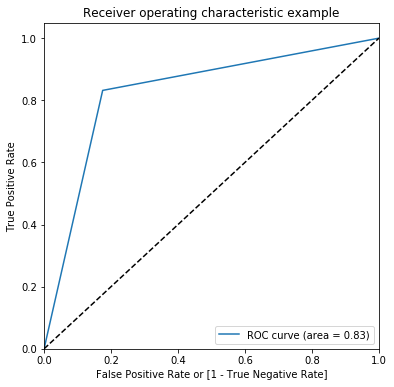

(array([0.        , 0.17502313, 1.        ]),
 array([0.        , 0.83188406, 1.        ]),
 array([2, 1, 0]))

In [72]:
draw_roc(original_ytest, y_pred_log_reg)

In [73]:
y_test_pred_prob = log_reg_sm.predict_proba(original_Xtest).round(2)
y_test_pred_prob = [i[1] for i in y_test_pred_prob]
y_test_pred_prob_df = pd.DataFrame(y_test_pred_prob)
y_test_pred_prob_df.columns = ['churn_prob_pred']

y_test_pred_final = pd.DataFrame({'churn':original_ytest, \
                                   'churn_prob':y_test_pred_prob_df.churn_prob_pred.values})

results_df = pd.DataFrame()
threshold_list=[]
recall_list=[]
precision_list=[]
roc_auc_score_list=[]

for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
  y_test_pred_final['predicted'] = y_test_pred_final.churn_prob.map(lambda x: 1 if x >= i else 0)
  threshold_list.append(i)
  recall_list.append(recall_score(y_test_pred_final.churn,y_test_pred_final.predicted))
  precision_list.append(precision_score(y_test_pred_final.churn,y_test_pred_final.predicted))
  roc_auc_score_list.append(roc_auc_score(y_test_pred_final.churn,y_test_pred_final.predicted))

results_df['Threshold'] = threshold_list
results_df['Recall'] = recall_list
results_df['Precision'] = precision_list
results_df['ROC_AUC_Score'] = roc_auc_score_list
results_df  

,Threshold,Recall,Precision,ROC_AUC_Score
0,0.1,0.965217,0.111633,0.737465
1,0.2,0.921739,0.138321,0.777613
2,0.3,0.889855,0.163733,0.799877
3,0.4,0.857971,0.196547,0.817052
4,0.5,0.831884,0.231452,0.827783
5,0.6,0.797101,0.279756,0.833056
6,0.7,0.718841,0.332886,0.813444
7,0.8,0.594203,0.383178,0.766574
8,0.9,0.400000,0.485915,0.686494


**0.4 seems to be a good threshold. It gives us 85% recall and around 82% ROC_AUC_Score**

---

<i>

We have got a decent area under the curve and recall accuracy. We have chosen Recall is a target metric to be tuned because we need to predict to be churn customers as perfect as possible. 

Higher recall value means churn customers are predicted correctly. This number will also have some customers those are not going to be churned but are classified as churn.

Such incorrect classification does not negatively impact telecom company. Because predicting non-churn customers as churn might result in issue of some discount schemes to these customers resulting in more customer delight.
</i>


---



In [74]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
print(rfc)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [75]:
%%time

# Number of trees in random forest
n_estimators = [100,200,500,1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10,20,50,100]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [100, 200, 500, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 50, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Wall time: 999 µs
Compiler : 240 ms
Parser   : 1.72 s




---


**Using above mentioned grid params, we got following RandomForestClassifier best estimator and we predicted churn labels using this model. Below steps explain final stats that we have gathered using model prediction.**


---

```
RandomForestClassifier<br/>
(bootstrap=False, class_weight=None, criterion='gini',<br>
max_depth=None, max_features=10, max_leaf_nodes=None,<br>
min_impurity_decrease=0.0, min_impurity_split=None,<br>
min_samples_leaf=1, min_samples_split=4,<br>
min_weight_fraction_leaf=0.0, n_estimators=10,<br>
n_jobs=None, oob_score=False, random_state=None,<br>
verbose=0, warm_start=False)</br>
```



In [76]:
best_est = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [77]:
best_est.fit(original_Xtrain,original_ytrain)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [78]:
prediction = best_est.predict(original_Xtrain)
prediction

array([1, 1, 0, ..., 1, 1, 1])

In [79]:
print("Training recall score :",recall_score(original_ytrain, prediction))
print("Test accuracy_score: ",accuracy_score(original_ytrain, prediction).round(2)*100,"%")
print("Test roc_auc_score: ",roc_auc_score(original_ytrain, prediction).round(2)*100,"%")
print("Training confusion matrix :\n",confusion_matrix(original_ytrain, prediction))

Training recall score : 1.0
Test accuracy_score:  100.0 %
Test roc_auc_score:  100.0 %
Training confusion matrix :
 [[21623     0]
 [    0  1384]]


<b>Model has predicted train labels with 100% accuracy!!!!

But, this might be the case of overfitting. Let's validate by testing our model of test data.</b>

### Prediction on test data

In [81]:
y_pred_rfc = best_est.predict(original_Xtest)

log_reg_cf = confusion_matrix(original_ytest, y_pred_rfc)
print("Test confusion matrix :\n",log_reg_cf.round())

print("Test recall score: ",recall_score(original_ytest, y_pred_rfc).round(2)*100,"%")
print("Test accuracy_score: ",accuracy_score(original_ytest, y_pred_rfc).round(2)*100,"%")
print("Test roc_auc_score: ",roc_auc_score(original_ytest, y_pred_rfc).round(2)*100,"%")

Test confusion matrix :
 [[5328   77]
 [ 212  133]]
Test recall score:  39.0 %
Test accuracy_score:  95.0 %
Test roc_auc_score:  69.0 %


<b>Accuracy is quite high as compared to logistic regression model. But, recall score is quite low. 

This means that RandomForestClassifier is unable to predict most of the churning customers.</b>

In [82]:
y_test_pred_prob = best_est.predict_proba(original_Xtest).round(2)
y_test_pred_prob = [i[1] for i in y_test_pred_prob]
y_test_pred_prob_df = pd.DataFrame(y_test_pred_prob)
y_test_pred_prob_df.columns = ['churn_prob_pred']

y_test_pred_final = pd.DataFrame({'churn':original_ytest, \
                                   'churn_prob':y_test_pred_prob_df.churn_prob_pred.values})

results_df = pd.DataFrame()
threshold_list=[]
recall_list=[]
precision_list=[]
roc_auc_score_list=[]

for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
  y_test_pred_final['predicted'] = y_test_pred_final.churn_prob.map(lambda x: 1 if x >= i else 0)
  threshold_list.append(i)
  recall_list.append(recall_score(y_test_pred_final.churn,y_test_pred_final.predicted))
  precision_list.append(precision_score(y_test_pred_final.churn,y_test_pred_final.predicted))
  roc_auc_score_list.append(roc_auc_score(y_test_pred_final.churn,y_test_pred_final.predicted))

results_df['Threshold'] = threshold_list
results_df['Recall'] = recall_list
results_df['Precision'] = precision_list
results_df['ROC_AUC_Score'] = roc_auc_score_list
results_df  

,Threshold,Recall,Precision,ROC_AUC_Score
0,0.1,0.852174,0.232411,0.836263
1,0.2,0.713043,0.377301,0.818964
2,0.3,0.597101,0.469248,0.776997
3,0.4,0.504348,0.530488,0.737928
4,0.5,0.402899,0.594017,0.692661
5,0.6,0.342029,0.674286,0.665742
6,0.7,0.252174,0.696000,0.622572
7,0.8,0.153623,0.697368,0.574684
8,0.9,0.072464,0.694444,0.535214


<b><i>
    Test predictions are not satisfactory enough. So, we will go ahead with selecting LogisticsRegression model only.
</i></b>    

# Feature Selection

Let's build another logistics regression model to check what are the features driving previously built model. Previous model was built using PCA modified dataset which is not quite interpreteble.

In [85]:
X = new_df.drop(['churn'], axis=1)
y = new_df['churn']
print("X.shape :",X.shape)
print("y.shape :",y.shape)

X.shape : (3458, 86)
y.shape : (3458,)


In [86]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=100)
print("X_train :",X_train.shape)
print("y_train :",y_train.shape)
print("X_test :",X_test.shape)
print("y_test :",y_test.shape)

X_train : (2766, 86)
y_train : (2766,)
X_test : (692, 86)
y_test : (692,)


In [87]:
%%time
from sklearn.feature_selection import RFE
rfe = RFE(log_reg_2, 15)             
rfe = rfe.fit(X_train, y_train)

In [89]:
col = X_train.columns[rfe.support_]
col

Index(['loc_og_mou_8', 'total_og_mou_8', 'loc_ic_mou_8', 'total_ic_mou_8',
       'spl_ic_mou_8', 'date_of_last_rech_8', 'monthly_2g_8', 'monthly_3g_8',
       'vbc_3g_8', 'avg_monthly_3g_av67', 'avg_offnet_mou_av67',
       'avg_total_ic_mou_av67', 'avg_total_og_mou_av67', 'avg_onnet_mou_av67',
       'aon_months'],
      dtype='object')

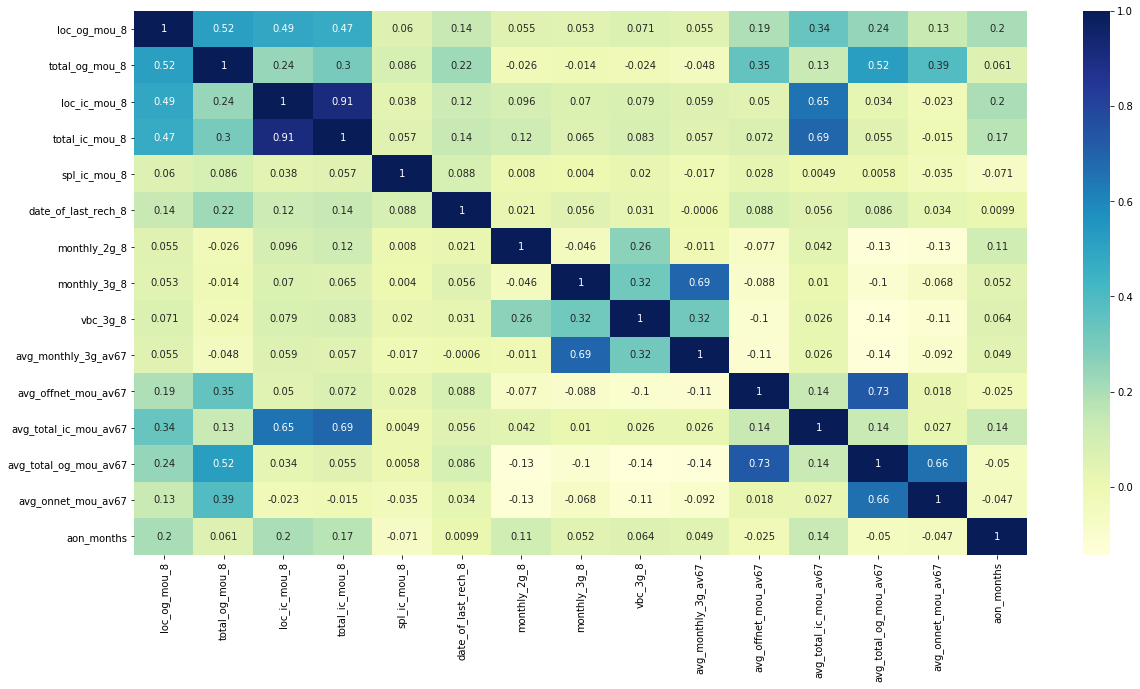

In [91]:
# Correlation heatmap to identify colinearity between RFE selected independent variables
corr = X_train[col].corr()

fig = plt.figure(figsize=(20,10))
sns.heatmap(corr,cmap="YlGnBu",annot=True)

fig.show()

<b>
    `loc_ic_mou_8` and `total_ic_mou_8` have high +ve correlation. One of the will have to be dropped during further analysis.
</b>    

### Assessing the model with StatsModels

In [100]:
import statsmodels.api as sm1

In [103]:
#Defining a reusable function to build model
def build_model(X_train,y_train):
    X_train_sm = sm1.add_constant(X_train) 
    log_model = sm1.GLM(y_train,X_train_sm, family = sm1.families.Binomial())
    res = log_model.fit()
    print(res.summary())
    return X_train_sm   

In [104]:
X_train_rfe1 = build_model(X_train[col],y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2766
Model:                            GLM   Df Residuals:                     2750
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1180.5
Date:                Sun, 03 Nov 2019   Deviance:                       2361.0
Time:                        23:24:22   Pearson chi2:                 1.69e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.6537      0.110     -5.970      0.000      -0.868      -0.439
loc_og_mou_8       

<b>
All the RFE selected variables seems to be significant. Let's check multicollinearity between selected variables.
</b>    

In [106]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [107]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe1.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe1.values, i) for i in range(X_train_rfe1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
13,avg_total_og_mou_av67,23.43
11,avg_offnet_mou_av67,12.95
14,avg_onnet_mou_av67,10.80
4,total_ic_mou_8,6.99
3,loc_ic_mou_8,6.19
0,const,3.25
12,avg_total_ic_mou_av67,2.10
2,total_og_mou_8,2.02
8,monthly_3g_8,2.00
10,avg_monthly_3g_av67,1.98


VIF value is quite high for `avg_total_og_mou_av67` (>5).So, we will drop this variable from model.

In [109]:
X_train_rfe2 = X_train_rfe1.drop(columns='avg_total_og_mou_av67',axis=1)

# Buiild another model using remaining variables
X_train_rfe2 = build_model(X_train_rfe2,y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2766
Model:                            GLM   Df Residuals:                     2751
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1191.1
Date:                Sun, 03 Nov 2019   Deviance:                       2382.1
Time:                        23:33:14   Pearson chi2:                 1.91e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.3538      0.079     -4.476      0.000      -0.509      -0.199
loc_og_mou_8       

All variables are significant. Let's check VIF.

In [110]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe2.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe2.values, i) for i in range(X_train_rfe2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,total_ic_mou_8,6.98
3,loc_ic_mou_8,6.19
0,const,2.11
12,avg_total_ic_mou_av67,2.08
2,total_og_mou_8,2.00
8,monthly_3g_8,2.00
10,avg_monthly_3g_av67,1.98
1,loc_og_mou_8,1.75
13,avg_onnet_mou_av67,1.30
9,vbc_3g_8,1.25


`total_ic_mou_8` is explained better by other variables in the model. We have previously seen that variable `lo c_ic_mou_8` is having very strong correlationship with `total_ic_mou_8`. Hence this should be dropped.

In [112]:
X_train_rfe3 = X_train_rfe2.drop(columns='total_ic_mou_8',axis=1)

# Buiild another model using remaining variables
X_train_rfe3 = build_model(X_train_rfe3,y_train)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                 2766
Model:                            GLM   Df Residuals:                     2752
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1194.7
Date:                Sun, 03 Nov 2019   Deviance:                       2389.4
Time:                        23:39:02   Pearson chi2:                 2.43e+04
No. Iterations:                     7   Covariance Type:             nonrobust
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.3405      0.079     -4.323      0.000      -0.495      -0.186
loc_og_mou_8       

In [113]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe3.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe3.values, i) for i in range(X_train_rfe3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,loc_ic_mou_8,2.14
0,const,2.10
7,monthly_3g_8,2.00
9,avg_monthly_3g_av67,1.98
2,total_og_mou_8,1.87
11,avg_total_ic_mou_av67,1.82
1,loc_og_mou_8,1.74
12,avg_onnet_mou_av67,1.29
8,vbc_3g_8,1.25
10,avg_offnet_mou_av67,1.23


In [ ]:
def draw_boxplots(df,col_name_x,col_name_y):
  f, axes = plt.subplots(ncols=3, figsize=(12,3))
  sns.boxplot(x=col_name_x, y=col_name_y[0], data=df[df[col_name_y[0]]<df[col_name_y[0]].quantile(0.99)], ax=axes[0])
  sns.boxplot(x=col_name_x, y=col_name_y[1], data=df[df[col_name_y[1]]<df[col_name_y[1]].quantile(0.99)], ax=axes[1])
  sns.boxplot(x=col_name_x, y=col_name_y[2], data=df[df[col_name_y[2]]<df[col_name_y[2]].quantile(0.99)], ax=axes[2])
  plt.tight_layout()
  f.show()

In [114]:
telecom_churn_data.shape

(28757, 87)

In [ ]:
draw_boxplots